# Schrieffer-Wolff transformation for a transmon and a fluxonium system
We consider a system of capacitively coupled transmon and fluxonium. Approximating the transmona as a Duffing oscillator the Hamiltonian is

$$H = H^{(0)}_T + H^{(0)}_F + V$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F.$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b) = i q_{\mathrm{ZPF}}(b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

We will restrict ourselves to the case where $\phi_{ext, F} = \pi$, so that a parity selection rule applies to the matrix elements of the fluxonium charge operator. 


In [70]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
import cmath
from pysqkit import QubitSystem, Qubit
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers import solvkit
import qutip
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_sw as util
import copy
import os
import json

from IPython.display import display, Latex

# Introducing the qubits and the coupled system

In [71]:
parameters_set = {}


parameters_set["0"] = {"max_freq_t": 4.5, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.0, "induct_energy_f": .5, "joseph_energy_f": 8.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.03}
parameters_set["1"] = {"max_freq_t": 5.0, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.0, "induct_energy_f": .85, "joseph_energy_f": 5.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.015}

parameters_set["2"] = {"max_freq_t": 4.5, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.0, "induct_energy_f": 1.0, "joseph_energy_f": 4.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.02}

parameters_set["test"] = {"max_freq_t": 4.5, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 0.6, "induct_energy_f": 0.5, "joseph_energy_f": 4.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.02}

In [72]:
d_comp = 4

p_set = "2"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    dim_hilbert=levels_t
)

#Fluxonium
levels_f = 4

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
)
flx.diagonalize_basis(levels_f)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)
flx_freq = bare_system.state('01')[0] - bare_system.state('00')[0]
display(Latex(r'$f_{{flx}}/2 \pi = {} \, \mathrm{{MHz}} $'.format(flx_freq*1e3)))

<IPython.core.display.Latex object>

The coupling term represents the perturbation $V$ in the Schrieffer-Wollf perturbation theory. Notice that technically speaking $V$ is an unbounded operator and many of the results of Bravyi-Loss-DiVincenzo would not apply. However, one can use the strategy of truncating the Hilbert space and analyze how the perturbation result behave by taking the limit. Intuitively it is reasonable to consider the first 3 levels for the transmon and the first 4 for the fluxonium. We plot the relevant energy levels in this case.

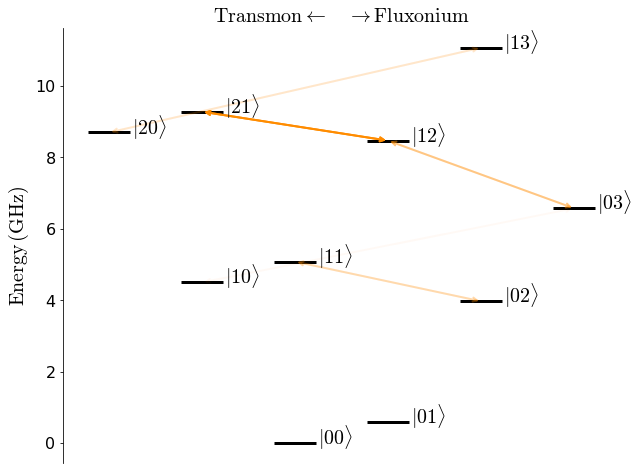

In [73]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13']

util.energy_levels_diagram(bare_system, level_list, show_drive=False)

The $ZZ$ coupling is defined as

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$


Using a second order Schrieffer-Wolff transformation we obtain the following expression for the $ZZ$ coupling coefficient generally defined as

$$\hbar \zeta_{ZZ}^{(SW)} = J_C^2 q_{\mathrm{ZPF}}^2 \biggl[\biggl(\frac{2 |q_{10}|^2}{\omega_{flx, 1} - (\omega_T + \delta_T) } \biggr) - \frac{|q_{21}|^2}{\omega_{flx, 2} - (\omega_T + \omega_{flx, 1}) } \biggr) + \frac{|q_{30}|^2}{\omega_{flx, 3} - \omega_T} \biggr]$$,
where $\omega_{flx, k} = E_{flx, k}/\hbar$ is the


In [74]:
def zz_sw(
    transm: Qubit,
    flx: Qubit,
    jc: float
):
    """
    Description
    ------------------------------------------------------------
    Returns the ZZ coupling according to the second order
    Schrieffer-Wolff formula
    """
    
    q_zpf = transm.charge_zpf
    omega_t = transm.freq
    delta_t = transm.anharm
    omega_flx, states_flx = flx.eig_states(4)
    omega_flx = omega_flx - omega_flx[0]
    q_10 = np.imag(get_mat_elem(flx.charge_op(), states_flx[1], states_flx[0]))
    q_21 = np.imag(get_mat_elem(flx.charge_op(), states_flx[2], states_flx[1]))
    q_30 = np.imag(get_mat_elem(flx.charge_op(), states_flx[3], states_flx[0]))
    coeff = 2*q_10**2/(omega_flx[1] - (omega_t + delta_t))
    coeff += -q_21**2/(omega_flx[2] - (omega_t + omega_flx[1]))
    coeff += q_30**2/(omega_flx[3] - omega_t)
    xi_zz = jc**2*q_zpf**2*coeff
    return xi_zz

def zz(system: QubitSystem) -> float:
    """
    Description
    ------------------------------------------------------------
    Returns the ZZ coupling according to the second order
    Schrieffer-Wolff formula
    """
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz
    

Example

In [75]:
display(Latex(r'$\xi_{{ZZ}}/h = {} \, \mathrm{{MHz}}$'.format(zz(coupled_sys)*1e3)))
display(Latex(r'$\xi_{{ZZ}}^{{(SW)}}/h = {} \, \mathrm{{MHz}}$'.format(zz_sw(transm, flx, jc)*1e3)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We now take three values of $J_C$ and sweep over the transmon frequency

In [76]:
min_freq = 4.2
max_freq = 5.8
n_points = 100
freq_list = list(np.linspace(min_freq, max_freq, n_points))
jc_dict = {"0":0.005, "1":0.015, "2":0.03}
zz_dict = {}
zz_sw_dict = {}

start = time.time()

for key in jc_dict.keys():
    zz_list = []
    zz_sw_list = []
    for freq in freq_list:
        transm_tmp = pysqkit.qubits.SimpleTransmon(
            label='T', 
            max_freq=freq, 
            anharm=parameters_set[p_set]["anharm_t"],
            dim_hilbert=levels_t,
        )
        coupled_sys_tmp = transm_tmp.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, 
                                               strength=jc_dict[key])
        zz_list.append(zz(coupled_sys_tmp))
        zz_sw_list.append(zz_sw(transm_tmp, flx, jc_dict[key]))
    zz_dict[key] = zz_list 
    zz_sw_dict[key] = zz_sw_list

end = time.time()

print("Computation time = {} s".format(end - start))
        


Computation time = 43.88691449165344 s


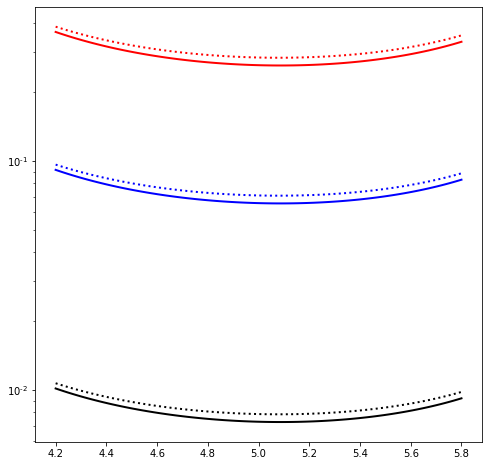

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogy(freq_list, np.abs(np.array(zz_dict["0"]))*1e3, linewidth=2.0, color='black')
ax.semilogy(freq_list, np.abs(np.array(zz_sw_dict["0"]))*1e3, linewidth=2.0, linestyle=':', color='black')
ax.semilogy(freq_list, np.abs(np.array(zz_dict["1"]))*1e3, linewidth=2.0, color='blue')
ax.semilogy(freq_list, np.abs(np.array(zz_sw_dict["1"]))*1e3, linewidth=2.0, linestyle=':', color='blue')
ax.semilogy(freq_list, np.abs(np.array(zz_dict["2"]))*1e3, linewidth=2.0, color='red')
ax.semilogy(freq_list, np.abs(np.array(zz_sw_dict["2"]))*1e3, linewidth=2.0, linestyle=':', color='red')
plt.show()

We now perform a similar comparison, but with the $YZ$ term associated with the transformed charge operator of the fluxonium.

In [79]:
def mu_yz_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
#     print("yz0 = {}".format(yz0))
#     print("yz1 = {}".format(yz1))
#     print("---------------------------------")
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

In [80]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

In [81]:
q_op = coupled_sys["F"].charge_op()
display(Latex(r'$\mu_{{YZ}} = {:.4f} $'.format(mu_yz_flx(comp_states, q_op))))
display(Latex(r'$\mu_{{IY}} = {:.4f} $'.format(mu_yi_flx(comp_states, q_op))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The Schrieffer-Wolff expression for these terms is
$$
\mu_{YI} = -\frac{J_{C} q_{ZPF}}{2}\biggl[\frac{|q_{30}|^2}{\omega_{flx, 3} - \omega_T} + \frac{|q_{21}|^2}{\omega_{flx, 2} - (\omega_T  + \omega_{flx, 1})}  \biggr]
$$,

$$
\mu_{YZ} = \frac{J_{C} q_{ZPF}}{2}\biggl[\frac{|q_{21}|^2}{\omega_{flx, 2} - (\omega_T  + \omega_{flx, 1})} - \frac{|q_{30}|^2}{\omega_{flx, 3} - \omega_T}  \biggr] + \frac{J_C q_{ZPF}| q_{10}^2|}{\omega_T - \omega_{flx, 1}}
$$

In [89]:
def mu_yz_flx_sw(
    transm: Qubit,
    flx: Qubit,
    jc: float
):
    q_zpf = transm.charge_zpf
    omega_t = transm.freq
    omega_flx, states_flx = flx.eig_states(4)
    omega_flx = omega_flx - omega_flx[0]
    q_10 = np.imag(get_mat_elem(flx.charge_op(), states_flx[1], states_flx[0]))
    q_21 = np.imag(get_mat_elem(flx.charge_op(), states_flx[2], states_flx[1]))
    q_30 = np.imag(get_mat_elem(flx.charge_op(), states_flx[3], states_flx[0]))
    coeff = q_21**2/(omega_flx[2] - (omega_t + omega_flx[1]))
    coeff += -q_30**2/(omega_flx[3] - omega_t)
    coeff += q_10**2/(omega_t - omega_flx[1]) 
    mu_yz = jc*q_zpf*coeff/2
    return mu_yz

def mu_yi_flx_sw(
    transm: Qubit,
    flx: Qubit,
    jc: float
):
    q_zpf = transm.charge_zpf
    omega_t = transm.freq
    omega_flx, states_flx = flx.eig_states(4)
    omega_flx = omega_flx - omega_flx[0]
    q_21 = np.imag(get_mat_elem(flx.charge_op(), states_flx[2], states_flx[1]))
    q_30 = np.imag(get_mat_elem(flx.charge_op(), states_flx[3], states_flx[0]))
    coeff = q_21**2/(omega_flx[2] - (omega_t + omega_flx[1]))
    coeff += q_30**2/(omega_flx[3] - omega_t)
    mu_yi = -jc*q_zpf*coeff/2
    return mu_yi

For the initial parameters we obtain

In [90]:
q_op = coupled_sys["F"].charge_op()
display(Latex(r'$\mu_{{YZ}} = {:.4f} $'.format(mu_yz_flx(comp_states, q_op))))
display(Latex(r'$\mu_{{YZ}}^{{(SW)}} = {:.4f} $'.format(mu_yz_flx_sw(transm, flx, jc))))
display(Latex(r'$\mu_{{IY}} = {:.4f} $'.format(mu_yi_flx(comp_states, q_op))))
display(Latex(r'$\mu_{{YI}}^{{(SW)}} = {:.4f} $'.format(mu_yi_flx_sw(transm, flx, jc))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [91]:
mu_yz_list = []
mu_yi_list = []
mu_yz_sw_list = []
mu_yi_sw_list = []


jc_cr = 0.015

start = time.time()

for freq in freq_list:
    transm_tmp = pysqkit.qubits.SimpleTransmon(
        label='T', 
        max_freq=freq, 
        anharm=parameters_set[p_set]["anharm_t"],
        dim_hilbert=levels_t,
    )
    coupled_sys_tmp = transm_tmp.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, 
                                           strength=jc_cr)
    state_label = ["00", "01", "10", "11"]
    comp_states_tmp = {}
    for label in state_label:
        state_tmp = coupled_sys_tmp.state(label)[1]
        loc = np.argmax(np.abs(state_tmp))
        phase = cmath.phase(state_tmp[loc])
        state_tmp = np.exp(-1j*phase)*state_tmp
        comp_states_tmp[label] = state_tmp
    q_op_tmp = coupled_sys_tmp["F"].charge_op()
    mu_yz_list.append(mu_yz_flx(comp_states_tmp, q_op_tmp))
    mu_yi_list.append(mu_yi_flx(comp_states_tmp, q_op_tmp))
    mu_yz_sw_list.append(mu_yz_flx_sw(transm_tmp, flx, jc_cr))
    mu_yi_sw_list.append(mu_yi_flx_sw(transm_tmp, flx, jc_cr))
    
end = time.time()

print("Computation time = {} s".format(end - start))

Computation time = 9.747042179107666 s


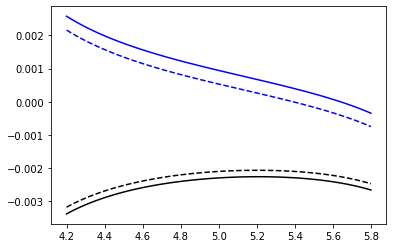

In [92]:
plt.plot(freq_list, mu_yz_list, linestyle='--', color='black')
plt.plot(freq_list, mu_yz_sw_list, color='black')
plt.plot(freq_list, mu_yi_list, linestyle='--', color='blue')
plt.plot(freq_list, mu_yi_sw_list, color='blue')
plt.show()

In [95]:
""" Saving data """

save = True
if save:
    path = os.getcwd() + '/tmp/'
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)
    paramfile = open(path + '/sw_params.txt', "w+")
    paramfile.write('The data where generated using ')
    paramfile.write('the following parameters. \n ')
    paramfile.write('Parameters for fluxonium \n ')
    paramfile.write('EC/h = %f' % flx.charge_energy + '\n')
    paramfile.write('EL/h = %f' % flx.induct_energy + '\n')
    paramfile.write('EJ/h = %f' % flx.joseph_energy + '\n')
    paramfile.write('Parameters for transmon \n ')
    paramfile.write('delta_T/2 \pi = %f' % transm.anharm + '\n')
    paramfile.write('In the plot with the cross resonance parameters \n')
    paramfile.write('the coupling is set to \n')
    paramfile.write('J_C/2 \pi = %f' % jc_cr + '\n')
    paramfile.close()
    
    with open("tmp/jc.txt", "w") as fp:
        json.dump(jc_dict, fp)
    with open("tmp/zz.txt", "w") as fp:
        json.dump(zz_dict, fp)
    with open("tmp/zz_sw.txt", "w") as fp:
        json.dump(zz_sw_dict, fp)
    with open("tmp/transm_freq.txt", "w") as fp:
        json.dump(freq_list, fp)
    with open("tmp/mu_yz.txt", "w") as fp:
        json.dump(mu_yz_list, fp)
    with open("tmp/mu_yi.txt", "w") as fp:
        json.dump(mu_yi_list, fp)
    with open("tmp/mu_yz_sw.txt", "w") as fp:
        json.dump(mu_yz_sw_list, fp)
    with open("tmp/mu_yi_sw.txt", "w") as fp:
        json.dump(mu_yi_sw_list, fp)

Creation of the directory /home/ciani/python/github/pysqkit/docs/research/transmon_fluxonium/schrieffer-wolff/tmp/ failed
